# Introduction

In this notebook, we want to study the two datasets in `beerAdv_beer_brewery.tsv` and in `rateBeer_beer_brewery.tsv`. The columns of these datasets are like this:

              beer_id ¦ beer_name ¦ brewery_id ¦ brewery_name
            
The idea of this notebook is to create a similarity measure in order to find the same elements in both these datasets. Once we have this similarity measure, we want to find the limit X such that:
- All pairs with a similarity value of $X' > X$ are considered as the same beer
- All pairs with a similarity value of $X'' < X$ are not taken into account.

In order to achieve this, this notebook is composed of three parts. The first part is some sort of simple Data Analysis. Then there will be the creation of the pairs and the similarity value. Finally the part to find the best value $X$.

## Table of contents

1. [Data Analysis](#data_analysis)
2. [Similarity Measure](#similarity)
3. [Matching the beers](#matching) 

Each parts is separated. Therefore, you don't have to run the previous parts in order to run a specific part.

In [163]:
# Usefule imports
import pandas as pd
import numpy as np
import codecs
from IPython.display import HTML
import matplotlib.pyplot as plt
import unicodedata
import random

from fuzzywuzzy import fuzz
import multiprocessing
from joblib import Parallel, delayed
import pickle

# For the Pyth§on notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

<a id='data_analysis'></a>

## Data Analysis

First, we need to analyze the data. It's a simple data analysis since we only have two usefull features: `beer_name` and `brewery_name`.

In [2]:
# Datasets
beerAdvocate_dataset = './data/beerAdv_beer_brewery.tsv'
rateBeer_dataset = './data/rateBeer_beer_brewery.tsv'

In [3]:
columns = ['beer_id', 'beer_name', 'brewery_id', 'brewery_name']

In [4]:
# Load the dataset with pandas
beerAdvocate = pd.read_table(beerAdvocate_dataset, header=None)
beerAdvocate.columns = columns
rateBeer = pd.read_table(rateBeer_dataset, header=None, encoding='utf-8')
rateBeer.columns = columns

Print the two datasets

In [5]:
beerAdvocate.head()

,beer_id,beer_name,brewery_id,brewery_name
0,14348,Eisbrau Czech,1,"Plzensky Prazdroj, a. s."
1,19099,Primus,1,"Plzensky Prazdroj, a. s."
2,19123,Gambrinus Pale,1,"Plzensky Prazdroj, a. s."
3,19274,Urutislav,1,"Plzensky Prazdroj, a. s."
4,41294,Pilsner Urquell 3.5%,1,"Plzensky Prazdroj, a. s."


In [6]:
rateBeer.head()

,beer_id,beer_name,brewery_id,brewery_name
0,4,Abita Bock,1,Abita Brewing Company
1,10731,Abita Louisiana Red Ale,1,Abita Brewing Company
2,114065,Abita Select Pecan Brown Ale,1,Abita Brewing Company
3,114981,Abita Select Amber Ale,1,Abita Brewing Company
4,117017,Abita American Wheat,1,Abita Brewing Company


We just stop two minutes here. We can see a problem with the encoding of the file for *beerAdvocate*. 

In [7]:
name = beerAdvocate.ix[12].beer_name
print(name)

Master PolotmavÃ½ 13Â°


The encoding here is **latin_1**. Therefore, we can find the UTF-8 encoding by doing this:

In [8]:
new_name = bytes(name,'latin_1').decode('utf-8')
print(new_name)

Master Polotmavý 13°


Let's do it everywhere for *beerAdvocate*!

In [9]:
def decode_from_latin_1(string):
    try:
        return bytes(string ,'latin_1').decode('utf-8')
    except:
        return string

In [10]:
for i in range(len(beerAdvocate)):
    # Change the name of the beer
    beerAdvocate.set_value(i, 'beer_name', decode_from_latin_1(beerAdvocate.ix[i].beer_name))
    beerAdvocate.set_value(i, 'brewery_name', decode_from_latin_1(beerAdvocate.ix[i].brewery_name))


In [11]:
beerAdvocate.ix[12].beer_name

'Master Polotmavý 13°'

For string comparison, it is better to remove all the accents. You will see later that we are using a library called `fuzzywuzzy`. And if we compare two letters, one with accent and one without it won't work.

In [12]:
fuzz.ratio("é", "e")

0

So, let's remove all the accents in the datasets.

In [13]:
def strip_accents(text):
    """
    Strip accents from input String.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

In [14]:
print("Name with accents and weird char: %s"%beerAdvocate.ix[12].beer_name)
print("Name without accents and weird char: %s"%strip_accents(beerAdvocate.ix[12].beer_name))

Name with accents and weird char: Master Polotmavý 13°
Name without accents and weird char: Master Polotmavy 13


The function `strip_accents` works pretty well. Let's apply it to all the elements in the two datasets.

In [15]:
for i in range(len(beerAdvocate)):
    # Change the name of the beer
    beerAdvocate.set_value(i, 'beer_name', strip_accents(beerAdvocate.ix[i].beer_name))
    beerAdvocate.set_value(i, 'brewery_name', strip_accents(beerAdvocate.ix[i].brewery_name))


In [16]:
for i in range(len(rateBeer)):
    # Change the name of the beer
    rateBeer.set_value(i, 'beer_name', strip_accents(rateBeer.ix[i].beer_name))
    rateBeer.set_value(i, 'brewery_name', strip_accents(rateBeer.ix[i].brewery_name))


Let's print the number of entries in each dataset.

In [17]:
print("Number of rows in beerAdvocate: %i"%(len(beerAdvocate)))
print("Number of rows in rateBeer: %i"%(len(rateBeer)))

Number of rows in beerAdvocate: 66056
Number of rows in rateBeer: 110359


Let's check the number of **unique** beers to see if it matches the number of rows in the dataset.

In [18]:
unique_beers_beerAdvocate = beerAdvocate.beer_name.unique()
unique_beers_rateBeer = rateBeer.beer_name.unique()

print("Number of unique beers in beerAdvocate: %i"%(len(unique_beers_beerAdvocate)))
print("Number of unique beers in rateBeer: %i"%(len(unique_beers_rateBeer)))

Number of unique beers in beerAdvocate: 56814
Number of unique beers in rateBeer: 110302


It's already interesting to see that some beers have the same name in both datasets. Let's take one of them and see if they have the same `brewery_name`.

In [19]:
duplicated_beers_beerAdvocate = beerAdvocate[beerAdvocate.beer_name.duplicated()].beer_name.unique()
duplicated_beers_rateBeer = rateBeer[rateBeer.beer_name.duplicated()].beer_name.unique()

print("Number of duplicated beer names in beerAdvocate: %i"%(len(duplicated_beers_beerAdvocate)))
print("Number of duplicated beer names in rateBeer: %i"%(len(duplicated_beers_rateBeer)))

Number of duplicated beer names in beerAdvocate: 2718
Number of duplicated beer names in rateBeer: 55


In [20]:
dup_beer_dup_brewery = []

# Create list of tuples. 
#   First entry is the name of the duplicated beer
#   Second entry is the list of Brewery that is duplicated
#   Third entry is the list of indices to remove them easily.
for dup_beer in duplicated_beers_beerAdvocate:
    subdf = beerAdvocate[beerAdvocate.beer_name == dup_beer]
    if any(subdf.brewery_name.duplicated()):
        dup_beer_dup_brewery.append((dup_beer, list(subdf[subdf.brewery_name.duplicated()]["brewery_name"]), list(subdf[subdf.brewery_name.duplicated()].index)))

In [21]:
print("Number of beers with duplicated brewery in beerAdvocate: %i"%(len(dup_beer_dup_brewery)))

Number of beers with duplicated brewery in beerAdvocate: 287


Just check how the function `duplicated` works. For example, if we have two times the same brewery, this means that we would have 3 times the same beer and the same brewery in the data set.

In [22]:
dup_beer_dup_brewery[3]

('Saison',
 ['Triumph Brewing Company', 'Triumph Brewing Company'],
 [22563, 43875])

In [23]:
beerAdvocate[(beerAdvocate.beer_name == "Saison") & (beerAdvocate.brewery_name == "Triumph Brewing Company")]

,beer_id,beer_name,brewery_id,brewery_name
17881,49387,Saison,1317,Triumph Brewing Company
22563,37383,Saison,15341,Triumph Brewing Company
43875,24385,Saison,4832,Triumph Brewing Company


At this point, we imagine that the three entries are the same. But we directly see that the brewery_id is different. And if we go check the breweries on beerAdvocate, we see that the three Breweries are not at the same place but they have the same name. Therefore, we cannot say that these three beers are the same. In order to get a better similarity measure, we need to add a bit mopre information about the breweries and the beers. Here are the features we scrap from the websites:
- For the brewery:
    - The address
- For the beer:
    - The ABV (Alcohol by Volume)
    - The Style

At this point, we will not scrap the websites nor use other data. This will be done later in the project. Therefore, we just remove the duplicate indices.

In [24]:
indices_to_remove = []
for i in range(len(dup_beer_dup_brewery)):
    indices_to_remove.extend(dup_beer_dup_brewery[i][2])

In [25]:
# Remove the indices in the dataset
beerAdvocate = beerAdvocate.drop(indices_to_remove, axis=0)
beerAdvocate.index = range(len(beerAdvocate))
beerAdvocate.tail()

,beer_id,beer_name,brewery_id,brewery_name
65667,76042,Foster's Gold,575,Foster's Group Limited
65668,917,Foster's Special Bitter,575,Foster's Group Limited
65669,918,Foster's Lager,575,Foster's Group Limited
65670,52642,Hefe Weissbier,5751,Bayerische Lowenbrauerei
65671,58058,Hefeweissbier Dunkel,5751,Bayerische Lowenbrauerei


Now, we need to the same for the rateBeer dataset.

In [26]:
dup_beer_dup_brewery = []

# Create list of tuples. 
#   First entry is the name of the duplicated beer
#   Second entry is the list of Brewery that is duplicated
#   Third entry is the list of indices to remove them easily.
for dup_beer in duplicated_beers_rateBeer:
    subdf = rateBeer[rateBeer.beer_name == dup_beer]
    if any(subdf.brewery_name.duplicated()):
        dup_beer_dup_brewery.append((dup_beer, list(subdf[subdf.brewery_name.duplicated()]["brewery_name"]), list(subdf[subdf.brewery_name.duplicated()].index)))

In [27]:
print("Number of beers with duplicated brewery in beerRate: %i"%(len(dup_beer_dup_brewery)))

Number of beers with duplicated brewery in beerRate: 4


In [28]:
dup_beer_dup_brewery

[('Traugott Simon Export', ['Udo Taubrich Betreuungs'], [9819]),
 ('Big Horn Saison',
  ['Big Horn Brewing Company (Ram International)'],
  [19577]),
 ('Yukon Lead Dog Ale', ['Yukon Brewing Company'], [37365]),
 ('Prison Brews Winter Ale', ['Prison Brews'], [77632])]

In [29]:
indices_to_remove = []
for i in range(len(dup_beer_dup_brewery)):
    indices_to_remove.extend(dup_beer_dup_brewery[i][2])

In [30]:
# Remove the indices in the dataset
rateBeer = rateBeer.drop(indices_to_remove, axis=0)
rateBeer.index = range(len(rateBeer))
rateBeer.tail()

,beer_id,beer_name,brewery_id,brewery_name
110350,77397,Jelling Bryghus Frode Fredegod,8804,Jelling Bryghus
110351,77398,Jelling Bryghus Poppo,8804,Jelling Bryghus
110352,77399,Jelling Bryghus Jelling Jol,8804,Jelling Bryghus
110353,89887,Jelling Bryghus Jalunki,8804,Jelling Bryghus
110354,97191,Jelling Bryghus Sildeglimt,8804,Jelling Bryghus


### Save the cleaned data set

Now that the datasets are cleaned, we can save them in a CSV format.

In [31]:
beerAdvocate.to_csv('./data/beerAdvocate_cleaned.csv', index=False, encoding='utf-8')
rateBeer.to_csv('./data/rateBeer_cleaned.csv', index=False, encoding='utf-8')

<a id='similarity'></a>
# Similarity

In this part, we want to create a similarity measure of the beers between the two datasets. Ideally, we would create a matrix of size $N\times M$, $N$ being the size of *RateBeer* dataset and $M$ being the size of *BeerAdvocate* dataset. But given the size of the two datasets, it's not possible. Therefore, the similarity function given [here](#sim_func) will return the five most similar objects. 

In [32]:
# Read the cleaned datasets
beerAdvocate = pd.read_csv('./data/beerAdvocate_cleaned.csv', dtype=str)
rateBeer = pd.read_csv('./data/rateBeer_cleaned.csv', dtype=str)

In [33]:
beerAdvocate.head()

,beer_id,beer_name,brewery_id,brewery_name
0,14348,Eisbrau Czech,1,"Plzensky Prazdroj, a. s."
1,19099,Primus,1,"Plzensky Prazdroj, a. s."
2,19123,Gambrinus Pale,1,"Plzensky Prazdroj, a. s."
3,19274,Urutislav,1,"Plzensky Prazdroj, a. s."
4,41294,Pilsner Urquell 3.5%,1,"Plzensky Prazdroj, a. s."


In [34]:
rateBeer.head()

,beer_id,beer_name,brewery_id,brewery_name
0,4,Abita Bock,1,Abita Brewing Company
1,10731,Abita Louisiana Red Ale,1,Abita Brewing Company
2,114065,Abita Select Pecan Brown Ale,1,Abita Brewing Company
3,114981,Abita Select Amber Ale,1,Abita Brewing Company
4,117017,Abita American Wheat,1,Abita Brewing Company


In [35]:
unique_rateBeer_breweries = rateBeer.brewery_name.unique()

<a id='sim_func'></a>
## Similarity measure

The similarity measure has been thought to be the most efficient possible. Instead of computing the whole matrix of similarities, we compute the similarities using the two features separately. This function takes a line of the *beerAdvocate* dataset and test it against the *rateBeer* dataset.

First, we start with the `brewery_name`. Indeed, it is possible to have beers with the same name but with different brewery. If it's the case, we cannot consider that they are the same. Therefore, we simply get the most similar `brewery_name` in the *rateBeer* dataset to the given entry of the *beerAdvocate* dataset. Then, we compute the similarity of the `beer_name` between the beers of the most similar brewery in *rateBeer* and the entry of the *beerAdvocate* dataset.

To compute the similarities, we use the library [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy). For the `brewery_name`, it's enough to use the function `token_set_ratio`. But for the beer, it's a little more complex due to all kind of changes in the name. First, we use the function `token_set_ratio`. Then, given if the name of the beer is a unique "generic" name or not, we use the function `ratio` or `partial_ratio` respectively. This helps to remove the elements matching together just by tokens.


In [74]:
def get_most_similar_brewery(brewery_test):
    """
        Return the most similar brewery in the dataset rateBeer given
        a brewery name in the beerAdvocate dataset.
        
        INPUT:
            brewery_test: String of a brewery name in the beerAdvocate dataset
            
        OUTPUT:
            brewery_sim: Similarity value between the brewery in the beerAdvocate dataset
                         and the most similar brewery name in the rateBeer dataset
                         
            idx_best_match_brewery: Index to get the name of the brewery in the rateBeer dataset
            
    
    """
    # Similarity of brewery_name
    brewery_sim = np.zeros(len(unique_rateBeer_breweries))
    for i in range(len(unique_rateBeer_breweries)):
        brewery_sim[i] = fuzz.token_set_ratio(brewery_test, unique_rateBeer_breweries[i])/100.0
        
    # Get the best match
    idx_best_match_brewery = np.argmax(brewery_sim)
    brewery_sim = np.max(brewery_sim) 
    
    return brewery_sim, idx_best_match_brewery

def similarity_between_beers(beer_test, beers_name_beerRate):
    """
        Return the list of similarity values between the beer_test from the 
        beerAdvocate dataset and a set of beers in the rateBeer dataset.
        
        INPUT:
            beer_test: Name of an active beer in the beerAdvocate dataset
            
            beer_names_beerRate: List of beers name in the beerRate dataset
            
        OUTPUT:
            beers_sim: List of similarities between the beer_test and the beers_name_beerRate
    
    """
    
    N = len(beers_name_beerRate)

    # Test the beers in previous list against beer from beerAdvocate
    beers_sim = np.zeros(N)
    for i in range(N):
        # First test is done with the token_set_ratio
        val1 = fuzz.token_set_ratio(beer_test, beers_name_beerRate[i])/100.0
        
        # Second test depends if the name of the beer_test has a space character.
        # If it has a space character, a partial ratio works fine due to the possibility
        # that the "words" can be swapped.
        #
        # If it doesn't have a space character, we need to be more strict, therefore using
        # the ratio is better. We also add the condition that if the two names are not 
        # exactly the same, it means that the beer in beers_name_beerRate is composed
        # of the generic name in beer_test plus some additional words => it's not the same
        # beer. (Think about Heineken and Heinken white.)
        
        if " " in beer_test:
            val2 = fuzz.partial_ratio(beer_test, beers_name_beerRate[i])/100.0
        else:
            val2 = fuzz.ratio(beer_test, beers_name_beerRate[i])/100.0
            if val2 < 1.0:
                val2 = val2/2.0

        beers_sim[i] = val1*val2
        
    return beers_sim

def tuple_matches(active_beer, beers_name, brewery_name, beers_sim, brewery_sim, nbr_match=5):
    """
        Return a list of tuples of size number_matches with the most similar beers to the 
        test beer.
        
        INPUT:
            active_beer: Name of the beer in the beerAdvocate dataset
            
            beer_names: List of beers name in the beerRate dataset
            
            breweri_name: Name of the brewery in the beerRate dataset that 
                          has the highest similarity.
                          
            beers_sim: List of similarity values for the beers in the beerRate dataset
            
            brewery_sim: Similarity value of the most matching brewery.
            
            number_matches: Number of best matches to return. Default is 5.
            
        OUTPUT:
            matches: List of tuples with the most matching beers to the active beer
                     in the beerAdvocate dataset.
    
    """ 
    
    N = len(beers_name)
    
    # Get the best similarities
    best_idx = np.argsort(beers_sim)[::-1]
    
    if N < 5:
        nbr_match = N
    
    # Get the 5 best matches and create a tuple
    matches = []
    for i in range(nbr_match):
        matches.append((beers_name[best_idx[i]], brewery_name, beers_sim[best_idx[i]]*brewery_sim))
                
    ## Double check 
    # If the elements have the same best values, we sort them by the 
    # difference of length between the beer names. 
    # This problem comes from the tokenisation for the similarity
    best_sim = matches[0][2]
    idx = [0]
    diff_length_beer_name = [abs(len(matches[0][0])-len(active_beer))]
    for i in range(1,nbr_match):
        if matches[i][2] == best_sim:
            idx.append(i)
            diff_length_beer_name.append(abs(len(matches[i][0])-len(active_beer)))
            
    best_idx = np.argsort(diff_length_beer_name)
    idx = np.asarray(idx)
    
    matches = np.asarray(matches)
    
    matches[idx] = matches[best_idx]
    
    return matches

In [75]:
def similarity(test):
    """
        Given a line in the beerAdvocate dataset, it returns a list of tuples containing the best matches in the 
        rateBeer dataset.
        
        INPUT:
            test: A line in the beerAdvocate dataset
            
        OUTPUT:
            matches: a list of tuples containing the best matches in the beerRate dataset to the INPUT line.
    """
    # Get brewery and beer name from beerAdvocate
    brewery = test.brewery_name.replace("'", "")
    beer = test.beer_name.replace("'", "")
    
    # Get the brewery in rateBeer that matches best the active brewery in the 
    # beerAdvocate dataset
    brewery_sim, idx_best_match_brewery = get_most_similar_brewery(brewery)    
    
    # List of beers in rateBeer with the brewery being the best match
    beers_name_rateBeer = list(rateBeer[rateBeer.brewery_name == unique_rateBeer_breweries[idx_best_match_brewery]].beer_name)
    
    # Get the similarity values for all beers in beer_names
    beers_sim = similarity_between_beers(beer, beers_name_rateBeer)
            
    # Get the best matches 
    matches = tuple_matches(beer, beers_name_rateBeer, unique_rateBeer_breweries[idx_best_match_brewery], beers_sim, brewery_sim)
                
    return matches

We can test here the similarity measure on single line of the *beerAdvocate* dataset.

In [76]:
bb=32
print(beerAdvocate.ix[bb])
print()
print(similarity(beerAdvocate.ix[bb]))

beer_id                               1814
beer_name       McNeill's Pullman's Porter
brewery_id                             100
brewery_name             McNeill's Brewery
Name: 32, dtype: object

[['McNeills Pullmans Porter' 'McNeills Brewery' '1.0']
 ['McNeills Troll' 'McNeills Brewery' '0.5767']
 ['McNeills Dubbel' 'McNeills Brewery' '0.511']
 ['McNeills Pilsner' 'McNeills Brewery' '0.5025']
 ['McNeills Kolsch' 'McNeills Brewery' '0.469']]


Prepare the Parallel implementation

In [77]:
nbr_jobs = multiprocessing.cpu_count()
nbr_jobs

8

Compute the list of similarities. **Warning**: On a Intel i7-6820HK CPU with 4 cores and 8 threads, it took 45 minutes.

In [78]:
%%time
M = len(beerAdvocate)
N = len(rateBeer)

sim = Parallel(n_jobs=nbr_jobs)(delayed(similarity)(beerAdvocate.ix[idx]) for idx in range(M))

CPU times: user 49.6 s, sys: 1.7 s, total: 51.3 s
Wall time: 44min 17s


Save the list as a pickle file.

In [79]:
pickle.dump(sim, open('./data/similarity.pickle', "wb"))

<a id='matching'></a>
# Matching the beers

Now, we want to match the beers together and create a new pandas DataFrame with the beers that are the same in the two datasets.

First, we can load the pickle file. **Warning**: Don't forget to unzip it if you did not run the [similarity](#similarity) section.

In [80]:
sim = pickle.load(open('./data/similarity.pickle', "rb"))

Print an example of the `sim` vector.

In [81]:
sim[8]

array([['Gambrinus Svetly 10 (Desitka)', 'Plzensky Prazdroj (SABMiller)',
        '0.89'],
       ['Gambrinus Premium Svetly Le?ak 12',
        'Plzensky Prazdroj (SABMiller)', '0.6141'],
       ['Gambrinus Dry', 'Plzensky Prazdroj (SABMiller)', '0.561946'],
       ['Gambrinus Bile', 'Plzensky Prazdroj (SABMiller)', '0.548418'],
       ['Gambrinus Nefiltrovane Sv?tle', 'Plzensky Prazdroj (SABMiller)',
        '0.4806']], 
      dtype='<U33')

Here, we can choose to check the first and second (or even more) best matches. But after checking many different examples, we see that if we also use the second element it won't be better. Therefore, we simply want to create the array of best maching beers and breweries by taking the first element in the `sim` list.

In [82]:
best_sim = np.zeros(len(sim))
best_match_beer = []
best_match_brewery = []

In [83]:
for i in range(len(sim)):
    best_sim[i] = sim[i][0][2]
    best_match_beer.append(sim[i][0][0])
    best_match_brewery.append(sim[i][0][1])

Create a new DataFrame.

In [84]:
matching_beers = beerAdvocate.copy()

In [85]:
matching_beers.columns = [s + '_beerAdvocate' for s in matching_beers.columns]

In [86]:
matching_beers['beer_name_rateBeer'] = best_match_beer
matching_beers['brewery_name_rateBeer'] = best_match_brewery
matching_beers['similarity'] = best_sim

In [87]:
matching_beers.head()


,beer_id_beerAdvocate,beer_name_beerAdvocate,brewery_id_beerAdvocate,brewery_name_beerAdvocate,beer_name_rateBeer,brewery_name_rateBeer,similarity
0,14348,Eisbrau Czech,1,"Plzensky Prazdroj, a. s.",Eisbrau Czech,Plzensky Prazdroj (SABMiller),0.890000
1,19099,Primus,1,"Plzensky Prazdroj, a. s.",Primus Sv&#283tle (Pale),Plzensky Prazdroj (SABMiller),0.178000
2,19123,Gambrinus Pale,1,"Plzensky Prazdroj, a. s.",Gambrinus Bile,Plzensky Prazdroj (SABMiller),0.658244
3,19274,Urutislav,1,"Plzensky Prazdroj, a. s.",Pilsner Urquell,Plzensky Prazdroj (SABMiller),0.046992
4,41294,Pilsner Urquell 3.5%,1,"Plzensky Prazdroj, a. s.",Pilsner Urquell 3.5%,Plzensky Prazdroj (SABMiller),0.890000


Let's sort the DataFrame by the similarity value.

In [106]:
matching_beers.sort_values(by='similarity', ascending=False, inplace=True)
matching_beers.index = range(len(matching_beers))

In [107]:
matching_beers.similarity.describe()

count    65672.000000
mean         0.540447
std          0.371982
min          0.000000
25%          0.174300
50%          0.477400
75%          1.000000
max          1.000000
Name: similarity, dtype: float64

Let's plot the histogram of the similarity values.

<function matplotlib.pyplot.show>

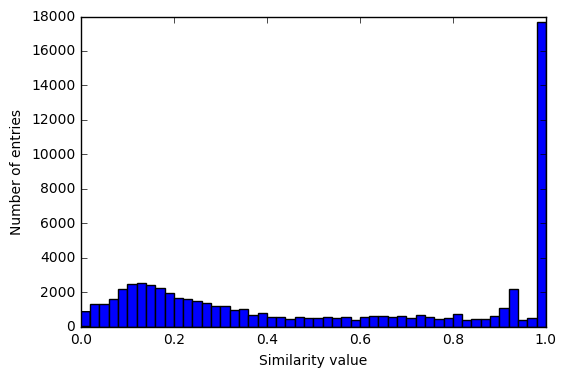

In [108]:
plt.hist(list(matching_beers.similarity), 50)
plt.xlabel('Similarity value')
plt.ylabel('Number of entries')
plt.show

We plot it again but without the similarity equal to 1.

<function matplotlib.pyplot.show>

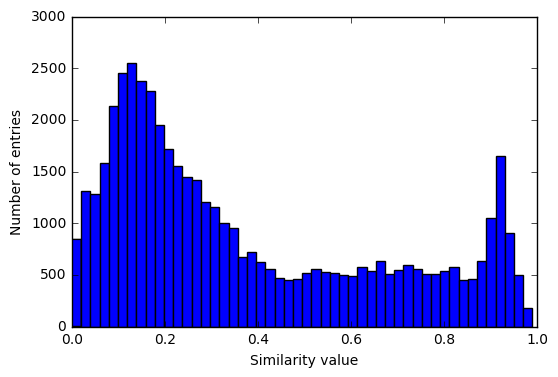

In [109]:
plt.hist(list(matching_beers[matching_beers.similarity < 1].similarity), 50)
plt.xlabel('Similarity value')
plt.ylabel('Number of entries')
plt.show

This histogram is really interesting. We see that we have a lot of beers where the matching is really good. So, if we want to be sure with a very high probability that the beers are the same, then we can choose to take only the entries with a similarity value of 1. But we will loose some beers.

In order to choose a good threshold value, we need to compute the recall. In order to compute it, we first manually labelled some matching as `True` for True positive and `False` as False positive. The first thing we need to do is to compute intervals (on the similarity values) such that the number of entries in each interval is the same.

In [225]:
def intervals(matching_beers, nbr_intervals):
    """
        Create intervals with same number of entries in each interval.
        
        The first interval is when the similarity is equal to 1. 
    """
    df_without_one = matching_beers[matching_beers.similarity < 1]
    N = len(df_without_one)
    
    nbr_per_interval = round(N/nbr_intervals)
    
    sim_values = [1.0]
    indices = [0]
    
    for i in range(nbr_intervals):
        idx = df_without_one.index[i*nbr_per_interval]
        indices.append(idx)
        sim_values.append(df_without_one.similarity[idx])
        
    idx = df_without_one.index[-1]
    indices.append(idx+1)
    sim_values.append(df_without_one.similarity[idx])
    
    return indices, sim_values 

def pick_random_entries(dataframe, index_start, index_end, number_entries):
    ""
    list_random_index = random.sample(range(index_start, index_end), number_entries)
    list_random_index.sort()
    
    random_entries = dataframe.ix[list_random_index][['beer_name_beerAdvocate', 'beer_name_rateBeer', 'brewery_name_beerAdvocate', 'brewery_name_rateBeer']]
    
    for i in random_entries.index:
        print(i)
    
    return random_entries
    

In [226]:
indices, sim_values = intervals(matching_beers, 30)
print(indices)
print(sim_values)

[0, 17495, 19101, 20707, 22313, 23919, 25525, 27131, 28737, 30343, 31949, 33555, 35161, 36767, 38373, 39979, 41585, 43191, 44797, 46403, 48009, 49615, 51221, 52827, 54433, 56039, 57645, 59251, 60857, 62463, 64069, 65672]
[1.0, 0.98999999999999999, 0.93000000000000005, 0.91180000000000005, 0.88, 0.81000000000000005, 0.75, 0.69420000000000004, 0.63959999999999995, 0.57620000000000005, 0.51600000000000001, 0.44968000000000002, 0.39483099999999999, 0.34999999999999998, 0.31781399999999999, 0.28999999999999998, 0.26500000000000001, 0.24360000000000001, 0.22259999999999999, 0.20335, 0.1862, 0.1711, 0.1575, 0.14422199999999999, 0.13147200000000001, 0.1188, 0.10607999999999999, 0.092450000000000004, 0.076787999999999995, 0.055759999999999997, 0.031433999999999997, 0.0]


In [229]:
interval = 3
pick_random_entries(matching_beers, indices[interval], indices[interval+1]-1, 20)


20789
20831
20921
20961
20969
21034
21043
21054
21095
21119
21162
21164
21276
21292
21359
21506
21546
21793
21800
21967


,beer_name_beerAdvocate,beer_name_rateBeer,brewery_name_beerAdvocate,brewery_name_rateBeer
20789,Trip XI,New Belgium The Trip XI Farmhouse Ale (Rosemar...,Elysian Brewing Company,Elysian Brewing Co.
20831,Double Barrel Scotch Ale,Phillips Double Barrel Scotch Ale,Phillips Brewing Company,Phillips Brewing Co.
20921,Ramsgate Gadds No. 3,Gadds No 3,Ramsgate Brewery,Ramsgate
20961,D'Ham Ambree,Les Brasseurs du Hameau dHam Ambree,Les Brasseurs du Hameau,Les Brasseurs du Hameau
20969,Tram Marzen,Tram-Marzen,Altes Tramdepot,Altes Tramdepot
21034,Chilly Invierno,Freetail Chilly Invierno,Freetail Brewing Company,Freetail Brewing Co.
21043,Coffee Stout,Stewarts Coffee Stout,Stewart's Brewing Co.,Stewarts Brewing Company
21054,Grand Cru,Stewarts Belgian Sunset Grand Cru,Stewart's Brewing Co.,Stewarts Brewing Company
21095,Old Yale Pale Ale,Old Yale Pale Ale,Old Yale Brewing Company,Old Yale Brewing Co
21119,Ovation Oktoberfest,Lindens Ovation Oktoberfest,Lindens Brewing Co.,Lindens Brewing Company


In [215]:
matching_beers[matching_beers.similarity >= 0.65].tail(20)


,beer_id_beerAdvocate,beer_name_beerAdvocate,brewery_id_beerAdvocate,brewery_name_beerAdvocate,beer_name_rateBeer,brewery_name_rateBeer,similarity
28365,53146,Terrapin Pumpkinfest,2372,Terrapin Beer Company,Terrapin Side Project Pumpkinfest,Terrapin Beer Company,0.65
28366,11874,Carolina Cask Conditioned Pale Ale,1499,Carolina Brewing Company,Carolina Pale Ale,Carolina Brewing Company,0.65
28367,3700,Columbus Pale Ale,341,Columbus Brewing Company,Columbus Brewing Pale Ale,Columbus Brewing Company,0.65
28368,76336,Devil Bird (2010),23635,Lavery Brewing Company,Lavery Devil Bird Holiday Ale 2010,Lavery Brewing Company,0.65
28369,36357,Burgbrau Pilsener,7911,Jahns Brau,Burgbrau Premium Pilsener,Jahns-Brau (Christoph Jahn Erben Brauerei),0.65
28370,58658,MateVeza Organic Black Lager,15886,Mateveza Brewing Company,Mateveza Black Lager,MateVeza Brewing Company,0.65
28371,48871,Milly's Hoplicious,1285,Milly's Tavern,Millys Tavern Hoplicious,Millys Tavern,0.65
28372,49971,Big River Maibock,2617,Big River Grille & Brewing Works,Big River Grille Disney World Maibock,Big River Grille & Brewing Works Lake Buena Vi...,0.65
28373,7926,Park Pirminator,2706,Parkbrauerei / Park & Bellheimer AG,Park Pirminator,Parkbrauerei (Actris Group),0.65
28374,24002,Altottinger Naturtrub Zwickelbier,5139,Altottinger Hell-Brau GmbH,Altottinger Zwickelbier,Altottinger Hell-Brau,0.65


We found that if the similarity value is above or equal to **0.65**, the matching is pretty good. If we use a threshold of 0.6, the beers are not matching well already. 

In [ ]:
threshold = 0.65 # Chosen empirically
good_matching_beers = matching_beers[matching_beers.similarity >= threshold]
good_matching_beers.index = range(len(good_matching_beers))
print("Number of good matching beers: %i"%len(good_matching_beers))

Now, we want to be sure that we don't have duplicated values.

In [ ]:
len(good_matching_beers[good_matching_beers.beer_name_rateBeer.duplicated()])

Sadly, we have some duplicated values for the `beer_name_rateBeer`. Therefore, we need to find a way to remove them.

In [ ]:
duplicated_beer_names = good_matching_beers[good_matching_beers.beer_name_rateBeer.duplicated()].beer_name_rateBeer.unique()

We decide that we will class the duplicated beers using the function `ratio` of the `fuzzywuzzy` library. The entry with the best ratio on the `beer_name` and the `brewery_name` will stay. The other entries will be deleted.

There's just a special case. The beers with a "generic" name. We decide that we remove all of them if the ratio is smaller then 90%. The reason is that if we don't do that, it will match the generic name to a beer with the generic name and the smallest addition. For example, the generic name being *Heineken*, the beer *Heineken dry* will be more similary than the beer *Heineken white*. And both these beers are different from the beer with the generic name.

In [ ]:
index_to_remove = []
for bn in duplicated_beer_names:
    df = good_matching_beers[good_matching_beers.beer_name_rateBeer == bn]
    ratio = []
    for i in df.index:
        val1 = fuzz.ratio(df.ix[i]['beer_name_beerAdvocate'], df.ix[i]['beer_name_rateBeer'])/100
        val2 = fuzz.ratio(df.ix[i]['brewery_name_beerAdvocate'], df.ix[i]['brewery_name_rateBeer'])/100
        ratio.append(val1*val2)
    df['ratio'] = ratio
    max_ratio = np.max(ratio)
    beer_test = df.ix[df.index[0]].beer_name_rateBeer
    if " " in beer_test:
        index_to_remove.extend(list(df[df.ratio != max_ratio].index))
    else:
        if max_ratio < 0.9:
            index_to_remove.extend(list(df.index))
        else:
            index_to_remove.extend(list(df[df.ratio != max_ratio].index))

In [ ]:
good_matching_beers = good_matching_beers.drop(index_to_remove)
good_matching_beers.index = range(len(good_matching_beers))

Now that we removed some duplicated beers, we will only have the beers with the same ratio left. So, let's check the duplicated beers again.

In [ ]:
len(good_matching_beers[good_matching_beers.beer_name_rateBeer.duplicated()])

In [ ]:
duplicated_beer_names = good_matching_beers[good_matching_beers.beer_name_rateBeer.duplicated()].beer_name_rateBeer.unique()

Print the duplicated beers that remain to see what is the problem.

In [ ]:
index_to_remove = []
for bn in duplicated_beer_names:
    df = good_matching_beers[good_matching_beers.beer_name_rateBeer == bn]
    ratio = []
    for i in df.index:
        val1 = fuzz.ratio(df.ix[i]['beer_name_beerAdvocate'], df.ix[i]['beer_name_rateBeer'])/100
        val2 = fuzz.ratio(df.ix[i]['beer_name_rateBeer'], df.ix[i]['beer_name_beerAdvocate'])/100
        ratio.append(val1*val2)
    df['ratio'] = ratio 
    index_to_remove.extend(list(df.index))
    print(df[['beer_name_rateBeer', 'beer_name_beerAdvocate', 'similarity', 'ratio']])
    print()

Most of the remaining duplicates are difficult to match. A good example can be this one:
                
                        beer_name_rateBeer         |      beer_name_beerAdvocate
                Green Flash Anniversary Strong Ale | Green Flash Anniversary Ale 2003  
                Green Flash Anniversary Strong Ale | Green Flash Anniversary Ale 2004
                Green Flash Anniversary Strong Ale | Green Flash Anniversary Ale 2005
                
With just the name information, we cannot say which `beer_name` in the *beerAdvocate* dataset is corresponding to the one in the *rateBeer* dataset. Therefore, we decide to remove these remaining duplicates.

In [ ]:
good_matching_beers = good_matching_beers.drop(index_to_remove)
good_matching_beers.index = range(len(good_matching_beers))

We have now our **final** DataFrame of beers that matched together. We just print the number of beers we could matched and save it in a CSV file.

In [ ]:
print("Number of beers that matched: %i"%len(good_matching_beers))

We just add the ID of the *rateBeer* dataset for easier research later.

In [ ]:
beer_id_rateBeer = rateBeer.set_index('beer_name').to_dict()['beer_id']
brewery_id_rateBeer = rateBeer.set_index('brewery_name').to_dict()['brewery_id']

In [ ]:
beer_id_rateBeer_list = []
brewery_id_rateBeer_list = []
for i in range(len(good_matching_beers)):
    beer_id_rateBeer_list.append(beer_id_rateBeer[good_matching_beers.ix[i].beer_name_rateBeer])
    brewery_id_rateBeer_list.append(brewery_id_rateBeer[good_matching_beers.ix[i].brewery_name_rateBeer])
good_matching_beers['beer_id_rateBeer'] = beer_id_rateBeer_list
good_matching_beers['brewery_id_rateBeer'] = brewery_id_rateBeer_list

In [ ]:
# Rearrange columns to be beautiful =)
good_matching_beers = good_matching_beers[['beer_id_beerAdvocate', 'beer_name_beerAdvocate', 'brewery_id_beerAdvocate', 'brewery_name_beerAdvocate', 'beer_id_rateBeer', 'beer_name_rateBeer', 'brewery_id_rateBeer', 'brewery_name_rateBeer', 'similarity']]

In [ ]:
# Save the Cleaned CSV
good_matching_beers.to_csv('./data/matching_beers.csv', index=False)

